In [82]:
import pandas as pd
import requests
import io
import numpy as np  
from datetime import date, timedelta
import re
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import torch
import torch.nn as nn
# Import tensor dataset & data loader
from torch.utils.data import TensorDataset, DataLoader
# Import nn.functional
import torch.nn.functional as F
import torch.optim as optim
from typing import Union, Tuple
import os
import sys
import time
from collections import OrderedDict
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math
matplotlib.style.use('seaborn')
%matplotlib inline

In [95]:
df = pd.read_csv("output_G.txt")

In [96]:
df.columns

Index(['seq_id', 'AAAAA', 'AAAAC', 'AAAAG', 'AAAAT', 'AAACA', 'AAACC', 'AAACG',
       'AAACT', 'AAAGA',
       ...
       'TTTCT', 'TTTGA', 'TTTGC', 'TTTGG', 'TTTGT', 'TTTTA', 'TTTTC', 'TTTTG',
       'TTTTT', 'Taxa_label'],
      dtype='object', length=1026)

In [97]:
df.head()

,seq_id,AAAAA,AAAAC,AAAAG,AAAAT,AAACA,AAACC,AAACG,AAACT,AAAGA,...,TTTCT,TTTGA,TTTGC,TTTGG,TTTGT,TTTTA,TTTTC,TTTTG,TTTTT,Taxa_label
0,S003747738,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,Rhodobaca
1,S003747738,1,2,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,Rhodobaca
2,S003747738,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,Rhodobaca
3,S003747738,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,Rhodobaca
4,S003747738,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,Rhodobaca


In [98]:
y=np.array(df['Taxa_label'].astype('category').cat.codes)
df=df.drop(columns=['seq_id','Taxa_label'])

In [99]:
X=np.array(df.copy(), dtype=float)

In [127]:
X_train, X_val, Y_train, Y_val= train_test_split(X, y, test_size=0.25, random_state=1,stratify=y)

In [128]:
inputs = torch.from_numpy(X_train.astype(np.float32))
targets = torch.from_numpy(Y_train.astype(np.float32))
targets = targets.long()
# Define dataset
train_ds = TensorDataset(inputs, targets)

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [129]:
inputs = torch.from_numpy(X_val.astype(np.float32))
targets = torch.from_numpy(Y_val.astype(np.float32))
# Define dataset
targets = targets.long()
test_ds = TensorDataset(inputs, targets)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [130]:
targets.shape

torch.Size([7000])

In [131]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    scheduler: optim.Optimizer,
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=True):
  
  use_test = False
  if isinstance(data, DataLoader):
    train_loader = data
  elif isinstance(data, tuple):
    if len(data) == 2:
      train_loader, test_loader = data
      if not isinstance(train_loader, DataLoader):
        raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
      if not isinstance(test_loader, DataLoader):
        raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
      use_test = True
    else:
      raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
  
  criterion = nn.CrossEntropyLoss()
  model.train()
  losses = []
  test_losses=[]
  batch_total = len(train_loader)
  train_acc=[]
  test_acc=[]
  best_model=None
  min_loss=np.iinfo(0).max
  for epoch in range(max_epochs):
    samples_total = 0
    samples_correct = 0
    #scheduler.step()
    batch_loss=[]
    for batch_idx, batch in enumerate(train_loader):
      x, y = batch
      if cuda:
        x, y = x.cuda(), y.cuda()
      optimizer.zero_grad()
      output = model(x)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
      
      yhat = torch.argmax(output, dim=1)

      samples_total += len(y)
      samples_correct += torch.sum(yhat == y)
      batch_loss.append(loss.item())


    acc = float(samples_correct) / float(samples_total)
    train_acc.append(acc)
    tsamples_total = 0
    tsamples_correct = 0
    test_epoch_loss=[]
    if use_test:
      model.eval()

      for test_x, test_y in test_loader:
        if cuda:
          test_x, test_y = test_x.cuda(), test_y.cuda()
        test_output = model(test_x)
        test_loss = criterion(test_output, test_y)
        test_epoch_loss.append(test_loss.item())
        test_yhat = torch.argmax(test_output, dim=1)
        tsamples_total += len(test_y)
        tsamples_correct += torch.sum(test_yhat == test_y)


      tacc = float(tsamples_correct) / float(tsamples_total)
      test_acc.append(tacc)
      if mean(test_epoch_loss)<min_loss:
            min_loss = mean(test_epoch_loss)
            best_model= model.state_dict()
      model.train()
      sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs}  Loss: {mean(batch_loss):.6f} Acc: {acc:.2%} Test loss: {mean(test_epoch_loss):.6f} Test acc: {tacc:.2%}')
    else:
      sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs}  Loss: {mean(batch_loss):.6f} Acc: {acc:.2%}')
    losses.append(mean(batch_loss))
    test_losses.append(mean(test_epoch_loss))
  return losses,test_losses, train_acc,test_acc, best_model

In [139]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
  
    
    self.body = nn.Sequential(OrderedDict([
                                   ('conv1', nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, stride=1, padding=1)),
                                   ('relu1', nn.LeakyReLU()),
                                   ('bn1', nn.BatchNorm1d(5)),
                                   ('pool1', nn.MaxPool1d(kernel_size=2, stride=2)),
                                   ('conv2', nn.Conv1d(in_channels=5, out_channels=10, kernel_size=5, stride=1, padding=1)),
                                   ('relu2', nn.LeakyReLU()),
                                   ('bn2', nn.BatchNorm1d(10)),
                                   ('pool2', nn.MaxPool1d(kernel_size=2, stride=2)),

                                   ('flatten',Flatten()),
                                   ('linearlayer1',nn.Linear(2540, 500)),
                                    ('relu1', nn.LeakyReLU()),
                                   ('dropout',nn.Dropout(p=0.5)),
                                    ('linearlayer2',nn.Linear(500, 96)),
                                    ('softmax', nn.LogSoftmax(dim=1))
                                   #('pool4', nn.MaxPool2d(kernel_size=2, stride=2))
    ]))
  def forward(self, x):
    b, features = x.shape
    #print(b,n_steps, features)
    x = x.reshape([b,1,features])
    y = self.body(x)
    return y

In [140]:
cuda_available = torch.cuda.is_available()
cuda_available

True

In [146]:

start = time.time()
model = CNNModel()
if cuda_available:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[150, 200], gamma=0.1)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
losses,test_losses, train_acc,test_acc, best_model = train(model, optimizer,scheduler, (train_loader, test_loader), max_epochs=100,cuda=cuda_available)
end = time.time()
print(f'\nTraining took {end-start}s!')

Epoch: 99/100  Loss: 0.005300 Acc: 99.98% Test loss: 0.471216 Test acc: 88.40%%
Training took 45.32221221923828s!


In [147]:
def plot_loss(epochs,train_losses,test_losses):
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.plot(range(epochs),train_losses, label='train loss')
  plt.plot(range(epochs),test_losses,label='test loss')
  plt.title('CNN')
  plt.legend()
  plt.show()
def plot_acc(epochs,train_losses,test_losses):
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.plot(range(epochs),train_losses, label='train acc')
  plt.plot(range(epochs),test_losses,label='test acc')
  plt.title('CNN')
  plt.legend()
  plt.show()

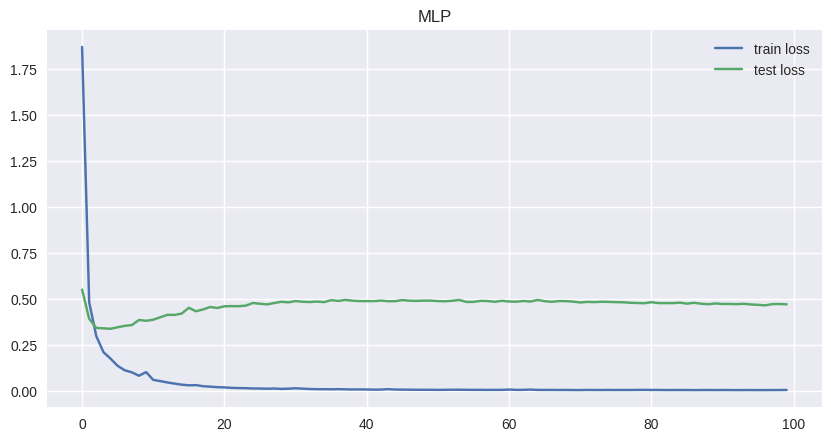

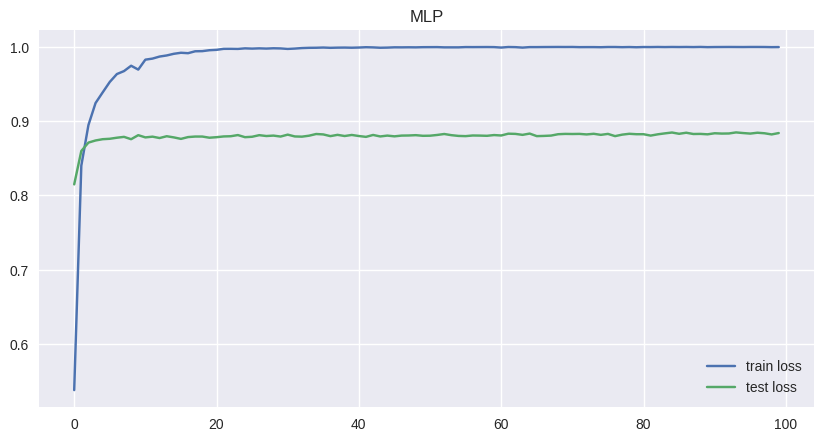

In [152]:
plot_loss(100,losses,test_losses)
plot_loss(100,train_acc,test_acc)

In [150]:
def validate(model: nn.Module, data: DataLoader, cuda=True):
  criterion = nn.CrossEntropyLoss()
  losses = []
  correct_samples = 0
  total_samples = 0
  for x, y in data:
      if cuda:
        x, y = x.cuda(), y.cuda()
      output = model(x)
      loss = criterion(output, y)
      yhat = torch.argmax(output, dim=1)
      losses.append(loss.item())
      correct_samples += torch.sum(yhat == y)
      total_samples += len(y)

  mean_losses = np.mean(losses)
  acc = float(correct_samples) / float(total_samples)
  print(f'Validation complete! Validation loss: {mean_losses:.6f}, Validation accuracy: {acc:.2%}')

  return mean_losses, acc

In [151]:
model = CNNModel()
if cuda_available:
    model = model.cuda()
model.load_state_dict(best_model)
validate(model, test_loader)

Validation complete! Validation loss: 0.532183, Validation accuracy: 87.36%


(0.5321833704199109, 0.8735714285714286)